# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

""" What I want to see more of is pandas and also some AI such as scikit-learn.  But most importantly I want to master pandas!"""

' What I want to see more of is pandas and also some AI such as scikit-learn.  But most importantly I want to master pandas!'

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# This DataFrame shows the elasticity score of each state meaning how sensitive a state is to changes in the national political enviorment.
states = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/political-elasticity-scores/elasticity-by-state.csv")
print(states.shape)
states.head()

(51, 2)


,state,elasticity
0,AK,1.16
1,RI,1.15
2,NH,1.15
3,MA,1.15
4,ME,1.13


In [25]:
states.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
state         51 non-null object
elasticity    51 non-null float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


In [26]:
print(states.describe())

       elasticity
count   51.000000
mean     1.016078
std      0.074514
min      0.800000
25%      0.970000
50%      1.010000
75%      1.070000
max      1.160000


In [39]:
# Political elasticity from low to high

low_high = states.sort_values("elasticity", ascending=True)

print(low_high.head(10))

   state  elasticity
50    DC        0.80
49    AL        0.89
48    GA        0.90
47    MS        0.92
46    DE        0.93
45    KY        0.94
44    OK        0.94
43    CA        0.94
42    VA        0.94
41    MO        0.95


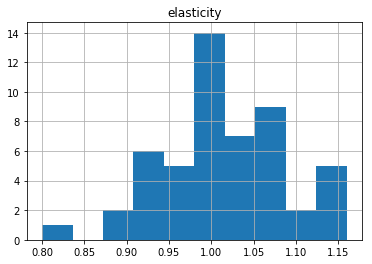

In [37]:
states.hist()
plt.show()

In [41]:
# This DataFrame shows the elasticity score of each district.
districts = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/political-elasticity-scores/elasticity-by-district.csv")
print(districts.shape)
districts.head()

(435, 2)


,district,elasticity
0,MI-5,1.24
1,IL-8,1.22
2,NV-4,1.22
3,MA-1,1.22
4,MA-6,1.21


In [44]:
print(districts.info())
districts.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 2 columns):
district      435 non-null object
elasticity    435 non-null float64
dtypes: float64(1), object(1)
memory usage: 6.9+ KB
None


,elasticity
count,435.000000
mean,0.997632
std,0.097523
min,0.720000
25%,0.940000
50%,1.000000
75%,1.060000
max,1.240000


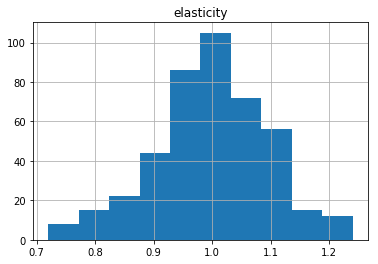

In [45]:
districts.hist()
plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.
          - I took the dataframes from both the district level and the state level that showed the elasticity of each state and district.  Elasticity meaning how sensitive
          each state or district is to changes in the national political enviorment.  I then found some summary statistics about each and plotted their respective histogram.

2.  What was the most challenging part of what you did?
          - The most challenging part for me was trying to find dataframes that I could work with that were csv.  Then importing the write csv link into the notebook. My main reason for picking this set of dta because I saw there were two so I thought I could merge them and compare their elasticity…didn't realize until it came down to the merge that if I was going to merge them I am going to have a lot of NaN values because there is no way to decipher the districts from the states.

3.  What was the most interesting thing you learned?
          - The most interesting thing I learned was how to take a link from the web and import it into a notebook and also what elasticity means with respect to polotics.


4.  What area would you like to explore with more time?
          - How to make our graphs/plots more eye appealing and when to use each type of graph/plot.



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.